In [240]:

import time
import os

import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_set, avg, row_number, struct, collect_list, col, count as sql_count, sum as sql_sum, coalesce, lit
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import Normalizer, BucketedRandomProjectionLSH
from pyspark.ml.evaluation import RegressionEvaluator

seed = 126784
DATASET = "100k"
BUCKET_LENGTH = 2.0
NUM_HASH_TABLES = 3
SIMILARITY_THRESHOLD = 1.0
TOP_K = 20
DEFAULT_RATING = 3.0
OUTPUT_DIR = "results"
METRICS_FILE = os.path.join(OUTPUT_DIR, "100k_metrics.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [241]:
spark = SparkSession.builder \
    .appName("126784-PRJ3B") \
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow") \
    .getOrCreate()
sc = spark.sparkContext

Ratings count: 100836
Movies count: 9742
Users count: 610


Text(0.5, 1.0, 'Rating Distribution')

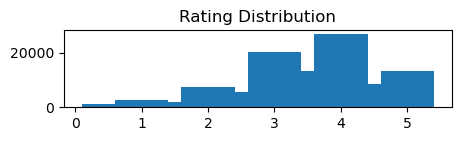

In [242]:
ratings_df = spark.read.csv(f"./datasets/{DATASET}/ratings.csv", header=True, inferSchema=True)
movies_df = spark.read.csv(f"./datasets/{DATASET}/movies.csv", header=True, inferSchema=True)

print(f"Ratings count: {ratings_df.count()}")
print(f"Movies count: {movies_df.count()}")
print(f"Users count: {ratings_df.select('userId').distinct().count()}")

rating_stats_pd = ratings_df.groupBy("rating").count().orderBy("rating").toPandas()
plt.figure(figsize=(5, 1))
plt.bar(rating_stats_pd['rating'], rating_stats_pd['count'])
plt.title('Rating Distribution')


### Sample Rating

In [243]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows


### Sample Movies

In [244]:
movies_df.show(5, truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows


In [245]:
ratings_train_df, ratings_test_df = ratings_df.randomSplit([0.9, 0.1], seed=seed)

print("Training set statistics:")
print(f"Total ratings: {ratings_train_df.count()}")
print(f"Unique users: {ratings_train_df.select('userId').distinct().count()}")
print(f"Unique movies: {ratings_train_df.select('movieId').distinct().count()}")
print(f"Average rating: {ratings_train_df.agg(avg('rating')).collect()[0][0]:.3f}")

print("\nTest set statistics:")
print(f"Total ratings: {ratings_test_df.count()}")
print(f"Unique users: {ratings_test_df.select('userId').distinct().count()}")
print(f"Unique movies: {ratings_test_df.select('movieId').distinct().count()}")
print(f"Average rating: {ratings_test_df.agg(avg('rating')).collect()[0][0]:.3f}")

Training set statistics:
Total ratings: 90916
Unique users: 610
Unique movies: 9372
Average rating: 3.501

Test set statistics:
Total ratings: 9920
Unique users: 598
Unique movies: 3653
Average rating: 3.506


In [246]:
user_index = ratings_train_df.select("userId").distinct().withColumn(
    "user_idx",
    row_number().over(Window.orderBy("userId")) - 1
)
num_users = user_index.count()
user_index.show(10)

+------+--------+
|userId|user_idx|
+------+--------+
|     1|       0|
|     2|       1|
|     3|       2|
|     4|       3|
|     5|       4|
|     6|       5|
|     7|       6|
|     8|       7|
|     9|       8|
|    10|       9|
+------+--------+
only showing top 10 rows


25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [247]:
train_with_idx = ratings_train_df.join(user_index, on="userId")
train_with_idx.toPandas().sample(5)

25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,userId,movieId,rating,timestamp,user_idx
49443,362,367,4.0,1530640164,361
70691,488,314,2.5,1112382491,487
75316,533,2455,3.0,1424754053,532
83070,596,150548,3.5,1535709519,595
57285,414,3625,2.0,1050934949,413


In [248]:
item_user_ratings = train_with_idx.groupBy("movieId") \
    .agg(
        collect_list(struct("user_idx", "rating")).alias("user_ratings"),
        sql_count("*").alias("num_ratings")
    )
item_user_ratings.select("movieId", "num_ratings") \
    .orderBy(col("num_ratings").desc()).show(10)

+-------+-----------+
|movieId|num_ratings|
+-------+-----------+
|    356|        295|
|    318|        283|
|    296|        278|
|    593|        253|
|   2571|        239|
|    260|        235|
|    110|        215|
|    480|        214|
|      1|        199|
|    589|        195|
+-------+-----------+
only showing top 10 rows


In [249]:
MIN_RATINGS = 5
filtered_items = item_user_ratings.filter(col("num_ratings") >= MIN_RATINGS)
print(f"Movies with more than {MIN_RATINGS} ratings: {filtered_items.count()}")

Movies with more than 5 ratings: 3463


In [250]:
def to_sparse_vector(user_ratings, size):
    """
    Converts a list of user ratings into a sparse vector.
    user_ratings: list of structs {user_idx, rating}
    size: total number of users
    """
    if not user_ratings:
        return Vectors.sparse(size, [], [])

    # sorting to make all one style
    sorted_ratings = sorted(user_ratings, key=lambda x: x.user_idx)

    indices = [r.user_idx for r in sorted_ratings]
    values = [float(r.rating) for r in sorted_ratings]

    return Vectors.sparse(size, indices, values)

In [251]:
item_vectors_rdd = filtered_items.rdd.map(
    lambda row: Row(
        movieId=row["movieId"],
        features=to_sparse_vector(row["user_ratings"], num_users),
        num_ratings=row["num_ratings"]
    )
)

item_vectors_df = spark.createDataFrame(item_vectors_rdd)

print(f"{item_vectors_df.count()} vectors created")
item_vectors_df.select("movieId", "num_ratings", "features").show(10)

25/06/04 23:53:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/04 23:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


3463 vectors created
+-------+-----------+--------------------+
|movieId|num_ratings|            features|
+-------+-----------+--------------------+
|      1|        199|(610,[0,4,6,14,16...|
|      2|         96|(610,[5,7,19,20,2...|
|      3|         47|(610,[0,5,18,31,4...|
|      4|          6|(610,[5,13,83,161...|
|      5|         46|(610,[5,30,44,57,...|
|      6|         93|(610,[0,5,10,17,2...|
|      7|         49|(610,[5,13,18,30,...|
|      8|          8|(610,[5,19,42,273...|
|      9|         15|(610,[150,178,216...|
|     10|        121|(610,[5,7,10,18,2...|
+-------+-----------+--------------------+
only showing top 10 rows


In [252]:
# data should be normalized for LSH
normalizer = Normalizer(inputCol="features", outputCol="norm_features", p=2.0)
normalized_df = normalizer.transform(item_vectors_df)
normalized_df.select("movieId", "num_ratings", "norm_features").show(10)

+-------+-----------+--------------------+
|movieId|num_ratings|       norm_features|
+-------+-----------+--------------------+
|      1|        199|(610,[0,4,6,14,16...|
|      2|         96|(610,[5,7,19,20,2...|
|      3|         47|(610,[0,5,18,31,4...|
|      4|          6|(610,[5,13,83,161...|
|      5|         46|(610,[5,30,44,57,...|
|      6|         93|(610,[0,5,10,17,2...|
|      7|         49|(610,[5,13,18,30,...|
|      8|          8|(610,[5,19,42,273...|
|      9|         15|(610,[150,178,216...|
|     10|        121|(610,[5,7,10,18,2...|
+-------+-----------+--------------------+
only showing top 10 rows


In [253]:
lsh = BucketedRandomProjectionLSH(
    inputCol="norm_features", outputCol="hashes", bucketLength=BUCKET_LENGTH, numHashTables=NUM_HASH_TABLES, seed=seed
)
lsh_model = lsh.fit(normalized_df)
hashed_df = lsh_model.transform(normalized_df)

similar_pairs = lsh_model.approxSimilarityJoin(
    normalized_df, normalized_df, SIMILARITY_THRESHOLD, distCol="distance"
).filter(col("datasetA.movieId") < col("datasetB.movieId"))

similarities_df = similar_pairs.withColumn(
    "cosine_similarity", 1 - (col("distance") ** 2) / 2
).select(
    col("datasetA.movieId").alias("movie_i"),
    col("datasetB.movieId").alias("movie_j"),
    "cosine_similarity"
)

In [254]:

reverse_similarities = similarities_df.selectExpr(
    "movie_j as movie_i", "movie_i as movie_j", "cosine_similarity"
)
full_similarities = similarities_df.union(reverse_similarities)

# get top-20 similar movies for each movie
window_spec = Window.partitionBy("movie_i").orderBy(col("cosine_similarity").desc())
final_similarities = full_similarities.withColumn("rank", row_number().over(window_spec)) \
                                      .filter(col("rank") <= TOP_K) \
                                      .drop("rank").cache()


In [255]:

def find_similar_movies(movie_id, k=5):
    """
    Find top-k similar movies for a given movie_id.
    """
    return final_similarities.filter(col("movie_i") == movie_id) \
        .join(movies_df, col("movie_j") == movies_df.movieId) \
        .orderBy(col("cosine_similarity").desc()) \
        .select("movie_j", "title", "cosine_similarity") \
        .limit(k).collect()


In [256]:

test_movie = ratings_train_df.groupBy("movieId").count().orderBy(col("count").desc()).first().movieId
test_movie_title = movies_df.filter(col("movieId") == test_movie).select("title").first().title


print(f"Test movie: {test_movie_title} (ID: {test_movie})")
for i, row in enumerate(find_similar_movies(test_movie), 1):
    print(f"{i}. {row.title} (similarity: {row.cosine_similarity:.3f})")

Test movie: Forrest Gump (1994) (ID: 356)


1. Shawshank Redemption, The (1994) (similarity: 0.637)
2. Jurassic Park (1993) (similarity: 0.627)
3. Pulp Fiction (1994) (similarity: 0.617)
4. Silence of the Lambs, The (1991) (similarity: 0.599)
5. Braveheart (1995) (similarity: 0.586)


In [257]:
test_with_idx = ratings_test_df.join(user_index, on="userId", how="inner")


In [258]:
# join test with similarities to find neighbor movies for each test rating
test_with_similarities = test_with_idx.alias("test") \
    .join(final_similarities.alias("sim"),
          col("test.movieId") == col("sim.movie_i")) \
    .select(
        col("test.userId"),
        col("test.movieId").alias("target_movie"),
        col("test.rating").alias("true_rating"),
        col("sim.movie_j").alias("neighbor_movie"),
        col("sim.cosine_similarity")
    )

In [259]:
# join with training ratings to get user's ratings for neighbor movies
test_with_neighbor_ratings = test_with_similarities.alias("tsim") \
    .join(train_with_idx.alias("train"),
          (col("tsim.userId") == col("train.userId")) &
          (col("tsim.neighbor_movie") == col("train.movieId"))) \
    .select(
        col("tsim.userId"),
        col("tsim.target_movie"),
        col("tsim.true_rating"),
        col("tsim.neighbor_movie"),
        col("tsim.cosine_similarity"),
        col("train.rating").alias("neighbor_rating")
    )

In [260]:
# calculate weighted average predictions
predictions_df = test_with_neighbor_ratings.groupBy("userId", "target_movie", "true_rating") \
    .agg(
        (sql_sum(col("cosine_similarity") * col("neighbor_rating")) /
         sql_sum(col("cosine_similarity"))).alias("predicted_rating")
    )

In [261]:
final_predictions = test_with_idx.alias("test") \
    .join(predictions_df.alias("pred"),
          (col("test.userId") == col("pred.userId")) &
          (col("test.movieId") == col("pred.target_movie")),
          how="left") \
    .select(
        col("test.userId"),
        col("test.movieId"),
        col("test.rating").alias("true_rating"),
        coalesce(col("pred.predicted_rating"), lit(DEFAULT_RATING)).alias("predicted_rating")
    )

print("Generated predictions for", final_predictions.count(),  "test ratings")
final_predictions.show(10)

Generated predictions for 9920 test ratings
+------+-------+-----------+------------------+
|userId|movieId|true_rating|  predicted_rating|
+------+-------+-----------+------------------+
|   148|    356|        4.0|               3.0|
|   148|   8368|        4.0|3.8601340526974117|
|   148|  30816|        5.0|               3.0|
|   148|  68954|        4.0|3.5166195918784053|
|   148|  72998|        4.0|3.8371904807130477|
|   148| 112852|        3.5|  3.71665694220925|
|   463|    110|        4.5| 4.154045476658502|
|   463|  36529|        4.5|               3.0|
|   471|   2571|        3.5|3.6791178600161594|
|   471|   6016|        4.0|               3.0|
+------+-------+-----------+------------------+
only showing top 10 rows


In [262]:
final_predictions.toPandas().to_csv(os.path.join(OUTPUT_DIR, "100k_predictions.csv"), index=False)

In [263]:
rmse_evaluator = RegressionEvaluator(
    metricName="rmse", labelCol="true_rating", predictionCol="predicted_rating"
)
mae_evaluator = RegressionEvaluator(
    metricName="mae", labelCol="true_rating", predictionCol="predicted_rating"
)

rmse = rmse_evaluator.evaluate(final_predictions)
mae = mae_evaluator.evaluate(final_predictions)

print(f"Final Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Final Results:
RMSE: 1.0427
MAE: 0.8109


In [264]:
global_avg = ratings_train_df.agg(avg("rating")).collect()[0][0]
neighbor_predictions = final_predictions.filter(col("predicted_rating") != DEFAULT_RATING).count()
total_predictions = final_predictions.count()
coverage = neighbor_predictions / total_predictions * 100

print(f"Coverage: {coverage:.1f}% ({neighbor_predictions}/{total_predictions} predictions from neighbors)")


Coverage: 36.4% (3612/9920 predictions from neighbors)


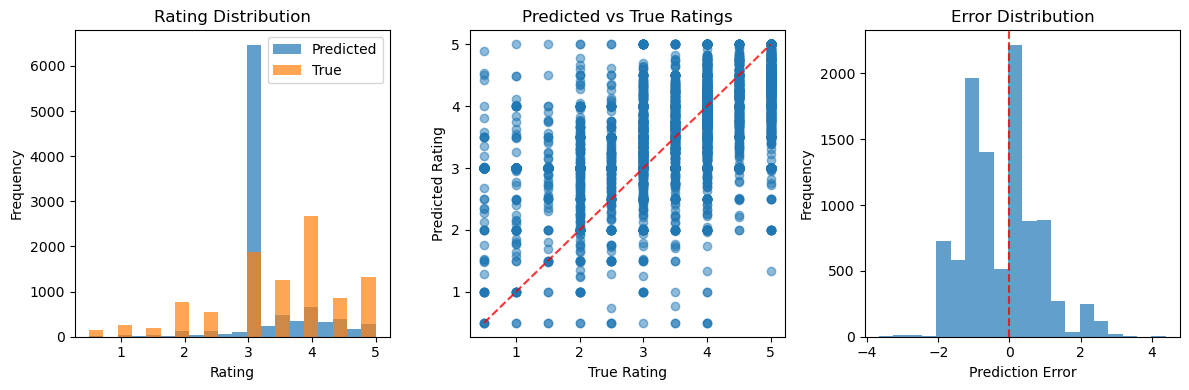


Error Statistics:
Mean Error: -0.2484
Std Error: 1.0127
MAE (manual): 0.8109
RMSE (manual): 1.0427


In [265]:
prediction_stats = final_predictions.select("predicted_rating", "true_rating").toPandas()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(prediction_stats['predicted_rating'], bins=20, alpha=0.7, label='Predicted')
plt.hist(prediction_stats['true_rating'], bins=20, alpha=0.7, label='True')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(prediction_stats['true_rating'], prediction_stats['predicted_rating'], alpha=0.5)
plt.plot([0.5, 5], [0.5, 5], 'r--', alpha=0.8)
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs True Ratings')

plt.subplot(1, 3, 3)
errors = prediction_stats['predicted_rating'] - prediction_stats['true_rating']
plt.hist(errors, bins=20, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()

print(f"\nError Statistics:")
print(f"Mean Error: {errors.mean():.4f}")
print(f"Std Error: {errors.std():.4f}")
print(f"MAE (manual): {abs(errors).mean():.4f}")
print(f"RMSE (manual): {np.sqrt((errors**2).mean()):.4f}")

In [266]:
results_row = pd.DataFrame([{
    "dataset": "100k",
    "rmse": rmse,
    "mae": mae,
    "bucketLength": BUCKET_LENGTH,
    "numHashTables": NUM_HASH_TABLES,
    "threshold": SIMILARITY_THRESHOLD,
    "top_k": TOP_K,
    "timestamp": time.strftime("%Y%m%d_%H%M%S")
}])
if os.path.exists(METRICS_FILE):
    old = pd.read_csv(METRICS_FILE)
    all_metrics = pd.concat([old, results_row], ignore_index=True)
else:
    all_metrics = results_row

all_metrics.to_csv(METRICS_FILE, index=False)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
# spark.stop()


RMSE: 1.0427, MAE: 0.8109
